## Week 2 Day 3

Now we get to more detail:

1. Different models

2. Structured Outputs

3. Guardrails

In [1]:
from dotenv import load_dotenv
from openai import AsyncOpenAI
from agents import Agent, Runner, trace, function_tool, OpenAIChatCompletionsModel, input_guardrail, GuardrailFunctionOutput
from typing import Dict
import sendgrid
import os
from sendgrid.helpers.mail import Mail, Email, To, Content
from pydantic import BaseModel

In [2]:
load_dotenv(override=True)

True

In [3]:
openai_api_key = os.getenv('OPENAI_API_KEY')
google_api_key = os.getenv('GOOGLE_API_KEY')
deepseek_api_key = os.getenv('DEEPSEEK_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")

if google_api_key:
    print(f"Google API Key exists and begins {google_api_key[:2]}")
else:
    print("Google API Key not set (and this is optional)")

if deepseek_api_key:
    print(f"DeepSeek API Key exists and begins {deepseek_api_key[:3]}")
else:
    print("DeepSeek API Key not set (and this is optional)")

if groq_api_key:
    print(f"Groq API Key exists and begins {groq_api_key[:4]}")
else:
    print("Groq API Key not set (and this is optional)")

OpenAI API Key exists and begins sk-proj-
Google API Key not set (and this is optional)
DeepSeek API Key not set (and this is optional)
Groq API Key exists and begins gsk_


In [4]:
instructions1 = "You are a sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write professional, serious cold emails."

instructions2 = "You are a humorous, engaging sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write witty, engaging cold emails that are likely to get a response."

instructions3 = "You are a busy sales agent working for ComplAI, \
a company that provides a SaaS tool for ensuring SOC2 compliance and preparing for audits, powered by AI. \
You write concise, to the point cold emails."

### It's easy to use any models with OpenAI compatible endpoints

In [5]:
GEMINI_BASE_URL = "https://generativelanguage.googleapis.com/v1beta/openai/"
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"
GROQ_BASE_URL = "https://api.groq.com/openai/v1"
OLLAMA_BASE_URL = "http://localhost:11434/v1"


In [6]:

# deepseek_client = AsyncOpenAI(base_url=DEEPSEEK_BASE_URL, api_key=deepseek_api_key)
# gemini_client = AsyncOpenAI(base_url=GEMINI_BASE_URL, api_key=google_api_key)
#groq_client = AsyncOpenAI(base_url=GROQ_BASE_URL, api_key=groq_api_key)
ollama_client = AsyncOpenAI(base_url=OLLAMA_BASE_URL, api_key='ollama')

# deepseek_model = OpenAIChatCompletionsModel(model="deepseek-chat", openai_client=deepseek_client)
# gemini_model = OpenAIChatCompletionsModel(model="gemini-2.0-flash", openai_client=gemini_client)
qwen_model = OpenAIChatCompletionsModel(model="qwen2.5:14b", openai_client=ollama_client)
llama3_model = OpenAIChatCompletionsModel(model="qwen2:7b", openai_client=ollama_client)
deepseek_model = OpenAIChatCompletionsModel(model="qwen2.5:14b", openai_client=ollama_client)
phi_model = OpenAIChatCompletionsModel(model="qwen3:8b", openai_client=ollama_client)

In [7]:
sales_agent1 = Agent(name="Qwen Sales Agent", instructions=instructions1, model=qwen_model)                         
sales_agent2 =  Agent(name="Llama3 Sales Agent", instructions=instructions2, model=llama3_model)
sales_agent3  = Agent(name="DeepSeek Sales Agent",instructions=instructions3,model=deepseek_model)

In [8]:
description = "Write a cold sales email"

tool1 = sales_agent1.as_tool(tool_name="sales_agent1", tool_description=description)
tool2 = sales_agent2.as_tool(tool_name="sales_agent2", tool_description=description)
tool3 = sales_agent3.as_tool(tool_name="sales_agent3", tool_description=description)

In [9]:
@function_tool
def send_html_email(subject: str, html_body: str) -> Dict[str, str]:
    """ Send out an email with the given subject and HTML body to all sales prospects """
    sg = sendgrid.SendGridAPIClient(api_key=os.environ.get('SENDGRID_API_KEY'))
    from_email = Email("mano@ieiworld.com")  # Change to your verified sender
    to_email = To("manomathew066@gmail.com")  # Change to your recipient
    content = Content("text/html", html_body)
    mail = Mail(from_email, to_email, subject, content).get()
    response = sg.client.mail.send.post(request_body=mail)
    print("send email success")
    return {"status": "success"}

In [10]:
subject_instructions = "You can write a subject for a cold sales email. \
You are given a message and you need to write a subject for an email that is likely to get a response."

html_instructions = "You can convert a text email body to an HTML email body. \
You are given a text email body which might have some markdown \
and you need to convert it to an HTML email body with simple, clear, compelling layout and design."

subject_writer = Agent(name="Email subject writer", instructions=subject_instructions, model=phi_model)
subject_tool = subject_writer.as_tool(tool_name="subject_writer", tool_description="Write a subject for a cold sales email")

html_converter = Agent(name="HTML email body converter", instructions=html_instructions, model=phi_model)
html_tool = html_converter.as_tool(tool_name="html_converter",tool_description="Convert a text email body to an HTML email body")

In [13]:
email_tools = [subject_tool, html_tool, send_html_email]

In [14]:
instructions ="You are an email formatter and sender. You receive the body of an email to be sent. \
You first use the subject_writer tool to write a subject for the email, then use the html_converter tool to convert the body to HTML. \
Finally, you use the send_html_email tool to send the email with the subject and HTML body. only HTML"


emailer_agent = Agent(
    name="Email Manager",
    instructions=instructions,
    tools=email_tools,
    model=deepseek_model,
    handoff_description="Convert an email to HTML and send it")

In [15]:
tools = [tool1, tool2, tool3]
handoffs = [emailer_agent]

In [16]:
sales_manager_instructions = "You are a sales manager working for ComplAI. You use the tools given to you to generate cold sales emails. \
You never generate sales emails yourself; you always use the tools. \
You try all 3 sales agent tools at least once before choosing the best one. \
You can use the tools multiple times if you're not satisfied with the results from the first try. \
You select the single best email using your own judgement of which email will be most effective. \
After picking the email, you handoff to the Email Manager agent to format and send the email."


sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=handoffs,
    model=deepseek_model)

message = "Send out a cold sales email addressed to Dear CEO from Alice"


# result = await Runner.run(sales_manager, message)

## Check out the trace:

https://platform.openai.com/traces

In [17]:
class NameCheckOutput(BaseModel):
    is_name_in_message: bool
    name: str

guardrail_agent = Agent( 
    name="Name check",
    instructions="Check if the user is including someone's personal name in what they want you to do.",
    output_type=NameCheckOutput,
    model=deepseek_model
)

In [18]:
@input_guardrail
async def guardrail_against_name(ctx, agent, message):
    result = await Runner.run(guardrail_agent, message, context=ctx.context)
    is_name_in_message = result.final_output.is_name_in_message
    return GuardrailFunctionOutput(output_info={"found_name": result.final_output},tripwire_triggered=is_name_in_message)

In [19]:
careful_sales_manager = Agent(
    name="Sales Manager",
    instructions=sales_manager_instructions,
    tools=tools,
    handoffs=[emailer_agent],
    model=deepseek_model,
    input_guardrails=[guardrail_against_name]
    )

message = "Send out a cold sales email addressed to Dear CEO from Alice"

# with trace("Protected Automated SDR"):
#    result = await Runner.run(careful_sales_manager, message)

## Check out the trace:

https://platform.openai.com/traces

In [20]:

message = "Send out a cold sales email addressed to Dear CEO from Head of Business Development"

with trace("Protected Automated SDR"):
    result = await Runner.run(careful_sales_manager, message)

send email success
send email success


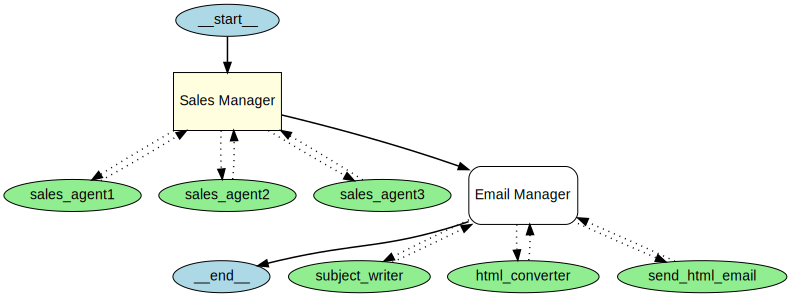

In [21]:
from agents.extensions.visualization import draw_graph
draw_graph(careful_sales_manager)

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/exercise.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#ff7800;">Exercise</h2>
            <span style="color:#ff7800;">• Try different models<br/>• Add more input and output guardrails<br/>• Use structured outputs for the email generation
            </span>
        </td>
    </tr>
</table>